Import necessary packages for Task B

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import joblib
import shutil
import skimage
from collections import Counter

from skimage.io import imread
from skimage.transform import resize
from skimage.transform import rescale
from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
#from sklearn.linear_model import LogisticRegression #did not converge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.metrics import accuracy_score

Tumour Image Formatting

In [2]:
def no_formatting_needed():
    #Cell for code if pkl file for sorted images already exists
    #Initialising Parameters for future steps
    base_name = 'tumour_img_TaskB_dataset'
    width = 256 #Kapernikov has 80 but I use 256 for apparent better accuracy (https://pubs.rsna.org/doi/full/10.1148/ryai.2019190015)
    include = {'glioma_tumor', 'meningioma_tumour', 'no_tumour', 'pituitary_tumor'}

In [3]:
def formatting_needed():
    #Cell for code if pkl file for sorted images does not exist
    
    #Object/Class to format tumour images (resizing, converting to array and storing in pkl file)
    def format_img(src, pklname, include, width=150, height=None):
        """
        load images from path, resize them and write them as arrays to a dictionary, 
        together with labels. The dictionary is written to a pickle file 
        named '{pklname}_{width}x{height}px.pkl'.
     
        Parameter
        ---------
        src: str
            path to data
        pklname: str
            path to output file
        width: int
            target width of the image in pixels
        include: set[str]
            set containing str
        """
     
        height = height if height is not None else width
     
        data = dict()
        data['description'] = 'resized ({0}x{1}) tumour images in grayscale for Task B'.format(int(width), int(height))
        data['label'] = []
        data['filename'] = []
        data['data'] = []   
     
        pklname = f"{pklname}_{width}x{height}px.pkl"
 
        # read all images in PATH, resize and write to DESTINATION_PATH
        for subdir in os.listdir(src):
            if subdir in include:
                print(subdir)
                current_path = os.path.join(src, subdir)
 
                for file in os.listdir(current_path):
                    if file[-3:] in {'jpg', 'png'}:
                        im = imread(os.path.join(current_path, file), as_gray=True) #if doesn't work remove as_gray bit
                        im = resize(im, (width, height)) #[:,:,::-1] #for consistency
                        data['label'].append(subdir[:-4])
                        data['filename'].append(file)
                        data['data'].append(im)
 
            joblib.dump(data, pklname)
    
    #Sorting the images to two folders; no tumour and tumour
    #Import label.csv file
    data = pd.read_csv('label.csv')
    #print(data) #debug line

    #Give the image labels values based on whether there is tumour and what type of tumour
    data.label[data.label == 'no_tumor'] = 0
    data.label[data.label == 'meningioma_tumor'] = 1
    data.label[data.label == 'glioma_tumor'] = 2
    data.label[data.label == 'pituitary_tumor'] = 3
    #print(data.dtypes) #debug line

    #Convert the label data type to integer
    data['label'] = data['label'].astype(str).astype(int)
    #print(data.dtypes) #debug line
    #print(data) #debug line

    #Create four arrays which contain the respective image names  
    no_tumour = []
    meningioma_tumour = []
    glioma_tumor = []
    pituitary_tumor = []

    for i in range(data.shape[0]):
        if data['label'][i] == 0:
            no_tumour.append(data['file_name'][i])
        elif data['label'][i] == 1:
            meningioma_tumour.append(data['file_name'][i])
        elif data['label'][i] == 2:
            glioma_tumor.append(data['file_name'][i])
        else:
            pituitary_tumor.append(data['file_name'][i])

    #print(len(no_tumour)) #debug line
    #print(len(meningioma_tumour)) #debug line
    #print(len(glioma_tumor)) #debug line
    #print(len(pituitary_tumor)) #debug line

    #Create a sorted subfolder to store the sorted images
    os.mkdir(os.path.join("./image", "sorted_TaskB"))

    #Create four subfolders in sorted folder
    os.mkdir(os.path.join("./image/sorted_TaskB", "no_tumour"))
    os.mkdir(os.path.join("./image/sorted_TaskB", "meningioma_tumour"))
    os.mkdir(os.path.join("./image/sorted_TaskB", "glioma_tumor"))
    os.mkdir(os.path.join("./image/sorted_TaskB", "pituitary_tumor"))

    #Copy the images into the respective subfolders
    src_dir = "./image"
    dst_dir1 = os.path.join("./image/sorted_TaskB", "no_tumour")
    dst_dir2 = os.path.join("./image/sorted_TaskB", "meningioma_tumour")
    dst_dir3 = os.path.join("./image/sorted_TaskB", "glioma_tumor")
    dst_dir4 = os.path.join("./image/sorted_TaskB", "pituitary_tumor")
    data_path = "./image/sorted_TaskB"

    for imageName in no_tumour:
        shutil.copy(os.path.join(src_dir, imageName), dst_dir1)

    for imageName in meningioma_tumour:
        shutil.copy(os.path.join(src_dir, imageName), dst_dir2)

    for imageName in glioma_tumor:
        shutil.copy(os.path.join(src_dir, imageName), dst_dir3)

    for imageName in pituitary_tumor:
        shutil.copy(os.path.join(src_dir, imageName), dst_dir4)

    #os.listdir(data_path)  #debug line

    #Initialising Parameters for resize function
    base_name = 'tumour_img_TaskB_dataset'
    width = 256 #Kapernikov has 80 but I use 256 for apparent better accuracy (https://pubs.rsna.org/doi/full/10.1148/ryai.2019190015)
    include = {'glioma_tumor', 'meningioma_tumour', 'no_tumour', 'pituitary_tumor'}
 
    #Create pkl file with resized images resized and converted to arrays
    format_img(src=data_path, pklname=base_name, width=width, include=include)
    print("Completed")

In [4]:
image_formatting=input("Does a pkl file containing the sorted images exist?(Please enter Y or N) ")

if image_formatting == "Y":
    no_formatting_needed()
elif image_formatting == "N":
    formatting_needed()
else:
    print("Incorrect input! Please run cell again and input either Y or N")

Does a pkl file containing the sorted images exist?(Please enter Y or N) Y


Loading the pickle file and some overview of the data

In [5]:
#Initialising Parameters for resize function
base_name = 'tumour_img_TaskB_dataset'
width = 256 #Kapernikov has 80 but I use 256 for apparent better accuracy (https://pubs.rsna.org/doi/full/10.1148/ryai.2019190015)
include = {'glioma_tumor', 'meningioma_tumour', 'no_tumour', 'pituitary_tumor'}

#Load pickle data file
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')

#some information about the data
print('number of samples: ', len(data['data']))
#print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image resolution: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
print('Data split:', Counter(data['label']))

number of samples:  3000
description:  resized (256x256) tumour images in grayscale for Task B
image resolution:  (256, 256)
labels: ['glioma_t' 'meningioma_tu' 'no_tu' 'pituitary_t']
Data split: Counter({'glioma_t': 860, 'meningioma_tu': 855, 'pituitary_t': 831, 'no_tu': 454})


Display an image for each label (MORE OF DEVELOPMENT CODE)

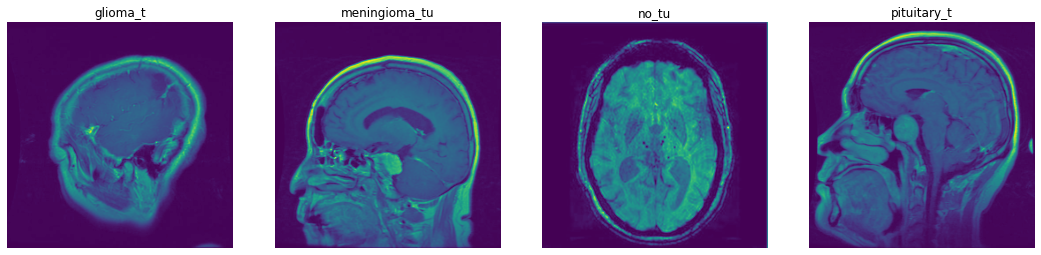

In [6]:
#Display an image for each label
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

Splitting the data to training and validation set and visualisation

In [7]:
#Extracting the X and y values from data
X = np.array(data['data'])
y = np.array(data['label'])

#Split data to train and test (75% train, 25% split)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    shuffle=True,
    random_state=42,
)

Visual Representation of the data split (MORE OF DEVELOPMENT CODE)

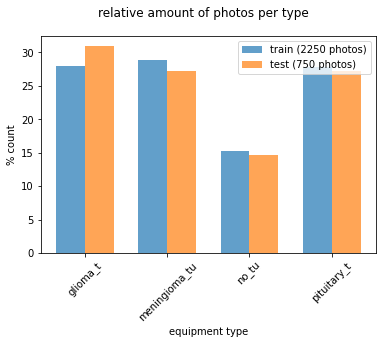

In [8]:
#Plotting the train/test split data
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

Create the classes on the transformers

In [9]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

Prepare training and validation data

In [34]:
# create an instance of each transformer
hogify = HogTransformer(
    #change parameters below for optimisation
    pixels_per_cell=(12, 12), 
    cells_per_block=(3, 3), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_hog = hogify.fit_transform(X_train)
X_train_prepared = scalify.fit_transform(X_train_hog)

print(X_train.shape)
print(X_train_prepared.shape) 

#transform validation data
X_test_hog = hogify.transform(X_test)
X_test_prepared = scalify.transform(X_test_hog)

print(X_test_prepared.shape) 

(2250, 256, 256)
(2250, 29241)
(750, 29241)


SGD Algorithm

In [35]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)

sgd_clf.fit(X_train_prepared, y_train)

y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print('')
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

cmx = confusion_matrix(y_test, y_pred)
print(cmx)

[ True False  True  True  True False  True False False  True  True  True
  True  True  True  True  True False  True  True  True  True  True  True
  True]

Percentage correct:  89.6
[[205  17   7   3]
 [ 17 170   7  10]
 [  3   6  96   5]
 [  2   1   0 201]]


Implement PCA to reduce number of features

K-Nearest Neighbours Method with PCA and different variance retention values

0.8
450
(2250, 450)
(750, 450)
For k = 1
Percentage correct:  92.93333333333334
confusion matrix is:
[[217  10   4   1]
 [  3 191   5   5]
 [  5   6  89  10]
 [  1   2   1 200]]

For k = 2
Percentage correct:  89.6
confusion matrix is:
[[224   5   2   1]
 [ 27 170   2   5]
 [  9  11  83   7]
 [  2   5   2 195]]

For k = 3
Percentage correct:  87.6
confusion matrix is:
[[203  17  10   2]
 [ 16 169   5  14]
 [  5  12  85   8]
 [  1   2   1 200]]

For k = 4
Percentage correct:  84.8
confusion matrix is:
[[211   9   8   4]
 [ 25 154   6  19]
 [  8  16  77   9]
 [  1   7   2 194]]

For k = 5
Percentage correct:  82.93333333333334
confusion matrix is:
[[190  25  10   7]
 [ 18 155   8  23]
 [  6  10  79  15]
 [  2   3   1 198]]

For k = 6
Percentage correct:  80.8
confusion matrix is:
[[199  15   9   9]
 [ 32 136  11  25]
 [  8  11  74  17]
 [  3   3   1 197]]

For k = 7
Percentage correct:  81.6
confusion matrix is:
[[189  23  10  10]
 [ 16 145  12  31]
 [  7   7  80  16]
 [  3   3   0 198]]

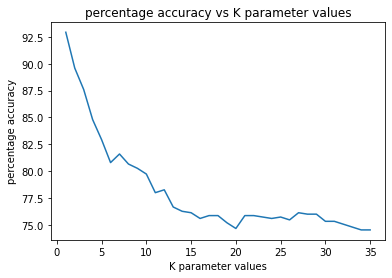

0.85
596
(2250, 596)
(750, 596)
For k = 1
Percentage correct:  93.06666666666666
confusion matrix is:
[[216  11   4   1]
 [  3 191   5   5]
 [  3   6  91  10]
 [  1   2   1 200]]

For k = 2
Percentage correct:  89.6
confusion matrix is:
[[223   6   2   1]
 [ 26 169   4   5]
 [  8  11  84   7]
 [  2   4   2 196]]

For k = 3
Percentage correct:  87.73333333333333
confusion matrix is:
[[207  13   9   3]
 [ 15 166   5  18]
 [  5   9  84  12]
 [  1   1   1 201]]

For k = 4
Percentage correct:  85.33333333333333
confusion matrix is:
[[211   8   8   5]
 [ 23 153   8  20]
 [  8  13  78  11]
 [  1   4   1 198]]

For k = 5
Percentage correct:  82.26666666666667
confusion matrix is:
[[193  23   8   8]
 [ 16 151  12  25]
 [  7  12  75  16]
 [  3   2   1 198]]

For k = 6
Percentage correct:  82.0
confusion matrix is:
[[204  11   9   8]
 [ 28 140  11  25]
 [  9  10  74  17]
 [  4   2   1 197]]

For k = 7
Percentage correct:  81.06666666666666
confusion matrix is:
[[188  22  10  12]
 [ 21 143  12  28

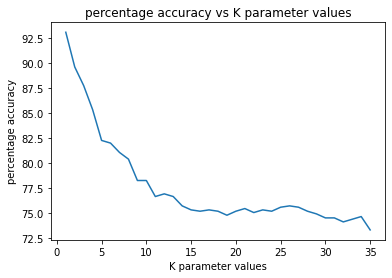

0.9
807
(2250, 807)
(750, 807)
For k = 1
Percentage correct:  93.2
confusion matrix is:
[[218  10   3   1]
 [  4 190   5   5]
 [  3   5  91  11]
 [  1   2   1 200]]

For k = 2
Percentage correct:  89.6
confusion matrix is:
[[222   6   3   1]
 [ 24 171   4   5]
 [  6  14  82   8]
 [  2   3   2 197]]

For k = 3
Percentage correct:  86.93333333333334
confusion matrix is:
[[205  14   8   5]
 [ 13 164   8  19]
 [  2  13  83  12]
 [  2   1   1 200]]

For k = 4
Percentage correct:  84.93333333333334
confusion matrix is:
[[210   7   8   7]
 [ 26 149   7  22]
 [  7  13  78  12]
 [  1   2   1 200]]

For k = 5
Percentage correct:  82.66666666666667
confusion matrix is:
[[192  22   9   9]
 [ 16 148  13  27]
 [  6   6  81  17]
 [  3   0   2 199]]

For k = 6
Percentage correct:  82.13333333333334
confusion matrix is:
[[200  14   8  10]
 [ 25 141  11  27]
 [  7  10  76  17]
 [  3   1   1 199]]

For k = 7
Percentage correct:  80.4
confusion matrix is:
[[188  20  11  13]
 [ 19 139  13  33]
 [  7   5  7

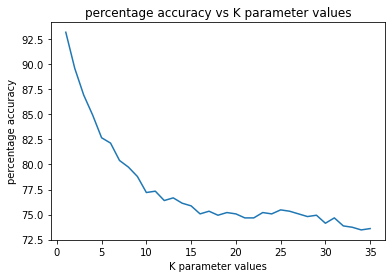

0.95
1145
(2250, 1145)
(750, 1145)
For k = 1
Percentage correct:  93.2
confusion matrix is:
[[217  10   4   1]
 [  4 190   5   5]
 [  3   4  92  11]
 [  1   2   1 200]]

For k = 2
Percentage correct:  90.4
confusion matrix is:
[[221   6   4   1]
 [ 23 172   4   5]
 [  5  10  87   8]
 [  2   3   1 198]]

For k = 3
Percentage correct:  86.93333333333334
confusion matrix is:
[[204  14   8   6]
 [ 12 161   9  22]
 [  2  10  86  12]
 [  2   0   1 201]]

For k = 4
Percentage correct:  85.6
confusion matrix is:
[[210   7   8   7]
 [ 23 150   8  23]
 [  8  10  82  10]
 [  2   1   1 200]]

For k = 5
Percentage correct:  82.8
confusion matrix is:
[[191  23   8  10]
 [ 14 148  12  30]
 [  6   6  83  15]
 [  3   0   2 199]]

For k = 6
Percentage correct:  82.4
confusion matrix is:
[[203  11   8  10]
 [ 24 138  12  30]
 [  7   8  79  16]
 [  3   1   2 198]]

For k = 7
Percentage correct:  79.73333333333333
confusion matrix is:
[[188  20  13  11]
 [ 17 131  19  37]
 [  7   5  82  16]
 [  4   1   2 1

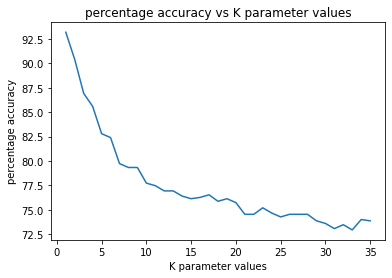

0.975
1428
(2250, 1428)
(750, 1428)
For k = 1
Percentage correct:  93.6
confusion matrix is:
[[218   8   4   2]
 [  4 190   5   5]
 [  2   3  94  11]
 [  0   3   1 200]]

For k = 2
Percentage correct:  90.26666666666667
confusion matrix is:
[[220   6   4   2]
 [ 23 172   4   5]
 [  6   9  87   8]
 [  2   3   1 198]]

For k = 3
Percentage correct:  86.93333333333334
confusion matrix is:
[[204  14   8   6]
 [ 12 161   9  22]
 [  2  10  86  12]
 [  2   0   1 201]]

For k = 4
Percentage correct:  85.46666666666667
confusion matrix is:
[[209   8   8   7]
 [ 23 151   9  21]
 [  8   7  83  12]
 [  2   2   2 198]]

For k = 5
Percentage correct:  82.66666666666667
confusion matrix is:
[[188  24  10  10]
 [ 13 149  12  30]
 [  5   6  84  15]
 [  3   0   2 199]]

For k = 6
Percentage correct:  82.4
confusion matrix is:
[[202  12   9   9]
 [ 23 137  14  30]
 [  6   8  81  15]
 [  3   1   2 198]]

For k = 7
Percentage correct:  80.26666666666667
confusion matrix is:
[[187  21  13  11]
 [ 16 132  19

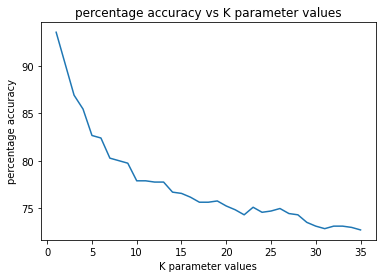

0.99
1700
(2250, 1700)
(750, 1700)
For k = 1
Percentage correct:  93.33333333333333
confusion matrix is:
[[217   9   5   1]
 [  4 190   5   5]
 [  3   3  93  11]
 [  0   3   1 200]]

For k = 2
Percentage correct:  90.13333333333334
confusion matrix is:
[[220   6   5   1]
 [ 24 171   4   5]
 [  6   9  87   8]
 [  2   3   1 198]]

For k = 3
Percentage correct:  87.06666666666666
confusion matrix is:
[[205  13   9   5]
 [ 12 160  10  22]
 [  2   9  87  12]
 [  2   0   1 201]]

For k = 4
Percentage correct:  85.33333333333333
confusion matrix is:
[[208   8  10   6]
 [ 25 148  10  21]
 [  8   7  86   9]
 [  2   2   2 198]]

For k = 5
Percentage correct:  83.06666666666666
confusion matrix is:
[[187  24  12   9]
 [ 11 148  15  30]
 [  5   3  89  13]
 [  3   0   2 199]]

For k = 6
Percentage correct:  82.26666666666667
confusion matrix is:
[[200  12  12   8]
 [ 24 136  15  29]
 [  6   8  83  13]
 [  3   1   2 198]]

For k = 7
Percentage correct:  79.86666666666666
confusion matrix is:
[[186  

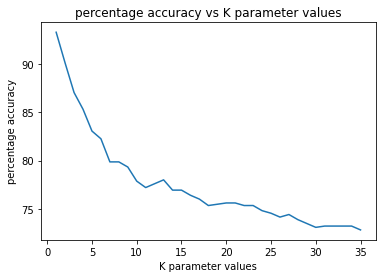

In [42]:
var_val = [0.80, 0.85, 0.90, 0.95, 0.975, 0.99]

def KNNClassifier(X_train, y_train, X_test,k):

    #Create KNN object with a K coefficient
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train) # Fit KNN model


    y_pred_knn = neigh.predict(X_test)
    return y_pred_knn

precentage = np.zeros(35)

for i in var_val:
    pca = PCA(i)
    pca.fit(X_train_prepared)

    #number of features selected
    print(i)
    print(pca.n_components_)

    NewX_train_prepared = pca.transform(X_train_prepared)
    NewX_test_prepared = pca.transform(X_test_prepared)

    print(NewX_train_prepared.shape) 
    print(NewX_test_prepared.shape)
    
    for j in range(1,36):
        y_pred_knn=KNNClassifier(NewX_train_prepared, y_train, NewX_test_prepared,j)
        print('For k =', j)
        precentage[j-1]=100*np.sum(y_pred_knn == y_test)/len(y_test)
        print('Percentage correct: ', precentage[j-1])
        cmx_knn = confusion_matrix(y_test, y_pred_knn)
        print('confusion matrix is:')
        print(cmx_knn)
        print('')
    
    #plot the accuracy of K
    K_values = np.linspace(1, 35, num=35)
    plt.plot(K_values,precentage)
    plt.xlabel("K parameter values")
    plt.ylabel("percentage accuracy")
    plt.title("percentage accuracy vs K parameter values")
    plt.show()

K-Nearest Neighbours Method without PCA

(2250, 29241)
(750, 29241)
For k = 1
Percentage correct:  93.6
confusion matrix is:
[[217  10   5   0]
 [  4 190   5   5]
 [  2   3  94  11]
 [  0   2   1 201]]

For k = 2
Percentage correct:  90.26666666666667
confusion matrix is:
[[221   6   5   0]
 [ 27 168   4   5]
 [  4   9  89   8]
 [  1   3   1 199]]

For k = 3
Percentage correct:  87.2
confusion matrix is:
[[205  13  11   3]
 [ 12 157  13  22]
 [  2   7  90  11]
 [  1   0   1 202]]

For k = 4
Percentage correct:  85.33333333333333
confusion matrix is:
[[206   8  12   6]
 [ 23 150  10  21]
 [  8   7  86   9]
 [  2   2   2 198]]

For k = 5
Percentage correct:  82.66666666666667
confusion matrix is:
[[187  24  14   7]
 [ 11 147  16  30]
 [  5   6  87  12]
 [  3   0   2 199]]

For k = 6
Percentage correct:  82.13333333333334
confusion matrix is:
[[199  12  14   7]
 [ 21 136  17  30]
 [  6   8  83  13]
 [  3   1   2 198]]

For k = 7
Percentage correct:  79.6
confusion matrix is:
[[184  22  17   9]
 [ 16 129  23  36]
 [  6   5  86  1

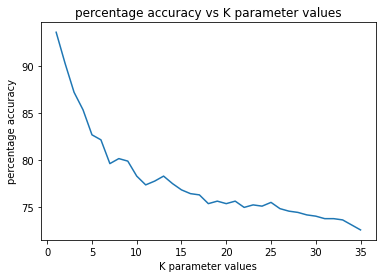

In [41]:
def KNNClassifier(X_train, y_train, X_test,k):

    #Create KNN object with a K coefficient
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train) # Fit KNN model


    y_pred_knn = neigh.predict(X_test)
    return y_pred_knn

precentage = np.zeros(35)

print(X_train_prepared.shape) 
print(X_test_prepared.shape)

for i in range(1,36):
    y_pred_knn=KNNClassifier(X_train_prepared, y_train, X_test_prepared,i)
    print('For k =', i)
    precentage[i-1]=100*np.sum(y_pred_knn == y_test)/len(y_test)
    print('Percentage correct: ', precentage[i-1])
    cmx_knn = confusion_matrix(y_test, y_pred_knn)
    print('confusion matrix is:')
    print(cmx_knn)
    print('')
    
#plot the accuracy of K
K_values = np.linspace(1, 35, num=35)
plt.plot(K_values,precentage)
plt.xlabel("K parameter values")
plt.ylabel("percentage accuracy")
plt.title("percentage accuracy vs K parameter values")
plt.show()

KNN with PCA and K = 47 or 48 (i.e sqrt(2250))

In [40]:
var_val = [0.80, 0.85, 0.90, 0.95, 0.975, 0.99]

def KNNClassifier(X_train, y_train, X_test,k):

    #Create KNN object with a K coefficient
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train) # Fit KNN model


    y_pred_knn = neigh.predict(X_test)
    return y_pred_knn

k_val = [47, 48]
#precentage = np.zeros(2)

for i in var_val:
    pca = PCA(i)
    pca.fit(X_train_prepared)

    #number of features selected
    print(i)
    print(pca.n_components_)

    NewX_train_prepared = pca.transform(X_train_prepared)
    NewX_test_prepared = pca.transform(X_test_prepared)

    print(NewX_train_prepared.shape) 
    print(NewX_test_prepared.shape)
    
    for j in k_val:
        y_pred_knn=KNNClassifier(NewX_train_prepared, y_train, NewX_test_prepared,j)
        print('For k =', j)
        precentage =100*np.sum(y_pred_knn == y_test)/len(y_test)
        print('Percentage correct: ', precentage)
        cmx_knn = confusion_matrix(y_test, y_pred_knn)
        print('confusion matrix is:')
        print(cmx_knn)
        print('')

0.8
450
(2250, 450)
(750, 450)
For k = 47
Percentage correct:  72.26666666666667
confusion matrix is:
[[176  31  11  14]
 [ 37 105  23  39]
 [  9   4  68  29]
 [  6   4   1 193]]

For k = 48
Percentage correct:  72.13333333333334
confusion matrix is:
[[180  26  11  15]
 [ 39 101  24  40]
 [  9   3  68  30]
 [  7   4   1 192]]

0.85
596
(2250, 596)
(750, 596)
For k = 47
Percentage correct:  72.0
confusion matrix is:
[[176  28  11  17]
 [ 37 102  24  41]
 [  8   3  69  30]
 [  7   4   0 193]]

For k = 48
Percentage correct:  72.0
confusion matrix is:
[[177  28  11  16]
 [ 37 101  24  42]
 [  8   3  69  30]
 [  7   4   0 193]]

0.9
807
(2250, 807)
(750, 807)
For k = 47
Percentage correct:  71.73333333333333
confusion matrix is:
[[176  28  11  17]
 [ 39  97  25  43]
 [  6   3  72  29]
 [  7   4   0 193]]

For k = 48
Percentage correct:  71.73333333333333
confusion matrix is:
[[177  26  11  18]
 [ 38  97  26  43]
 [  7   3  71  29]
 [  7   4   0 193]]

0.95
1145
(2250, 1145)
(750, 1145)
For

KNN without PCA and K = 47 or 48 (i.e sqrt(2250))

In [39]:
def KNNClassifier(X_train, y_train, X_test,k):

    #Create KNN object with a K coefficient
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train) # Fit KNN model


    y_pred_knn = neigh.predict(X_test)
    return y_pred_knn

k_val = [47, 48]
#precentage = np.zeros(2)

print(X_train_prepared.shape) 
print(X_test_prepared.shape)

for i in k_val:
    y_pred_knn=KNNClassifier(X_train_prepared, y_train, X_test_prepared,i)
    print('For k =', i)
    precentage=100*np.sum(y_pred_knn == y_test)/len(y_test)
    print('Percentage correct: ', precentage)
    cmx_knn = confusion_matrix(y_test, y_pred_knn)
    print('confusion matrix is:')
    print(cmx_knn)
    print('')

(2250, 29241)
(750, 29241)
For k = 47
Percentage correct:  72.13333333333334
confusion matrix is:
[[175  22  18  17]
 [ 39  97  28  40]
 [  6   3  78  23]
 [  7   4   2 191]]

For k = 48
Percentage correct:  71.73333333333333
confusion matrix is:
[[174  23  19  16]
 [ 40  96  28  40]
 [  6   4  77  23]
 [  7   4   2 191]]



SGD Method with PCA and different variance retentions

In [36]:
var_val = [0.80, 0.85, 0.90, 0.95, 0.975, 0.99]

def SGDClassifierobject(X_train, y_train, X_test):

    #Create SGD object
    sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
    sgd_clf.fit(X_train, y_train)

    y_pred = sgd_clf.predict(X_test)
    return y_pred

for i in var_val:
    pca = PCA(i)
    pca.fit(X_train_prepared)

    #number of features selected
    print(i)
    print(pca.n_components_)

    NewX_train_prepared = pca.transform(X_train_prepared)
    NewX_test_prepared = pca.transform(X_test_prepared)

    print(NewX_train_prepared.shape) 
    print(NewX_test_prepared.shape)

    y_pred=SGDClassifierobject(NewX_train_prepared, y_train, NewX_test_prepared)
    print(np.array(y_pred == y_test)[:25])
    print('')
    print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))
    cmx = confusion_matrix(y_test, y_pred)
    print('confusion matrix is:')
    print(cmx)
    print('')

0.8
450
(2250, 450)
(750, 450)
[ True False  True  True  True False False False False  True  True False
  True  True  True  True  True False False  True  True  True  True  True
  True]

Percentage correct:  87.33333333333333
confusion matrix is:
[[201  22   7   2]
 [ 20 165   7  12]
 [  5   5  92   8]
 [  4   3   0 197]]

0.85
596
(2250, 596)
(750, 596)
[ True False  True  True  True False  True False False  True  True  True
  True  True  True  True  True False False  True  True  True  True  True
  True]

Percentage correct:  89.46666666666667
confusion matrix is:
[[202  23   4   3]
 [ 18 171   4  11]
 [  5   3  95   7]
 [  0   1   0 203]]

0.9
807
(2250, 807)
(750, 807)
[ True False  True  True  True False  True False False  True  True  True
  True  True  True  True  True False False  True  True  True  True  True
  True]

Percentage correct:  87.06666666666666
confusion matrix is:
[[196  24   6   6]
 [ 17 168   6  13]
 [  5   5  92   8]
 [  4   3   0 197]]

0.95
1145
(2250, 1145)
(750

Decision Trees without PCA

In [37]:
split_params = [2, 5, 10, 20, 25, 50]

for i in split_params:
    tree_params={
        'criterion': 'entropy',
        'min_samples_split':i
    }
    clf_tree = tree.DecisionTreeClassifier(**tree_params)
    clf_tree.fit(X_train_prepared, y_train)
    
    print(X_train_prepared.shape) 
    print(X_test_prepared.shape)
    print('Accuracy Score on train data: ', accuracy_score(y_true=y_train, y_pred=clf_tree.predict(X_train_prepared)))
    print('Accuracy Score on test data: ', accuracy_score(y_true=y_test, y_pred=clf_tree.predict(X_test_prepared)))

    y_pred_test = clf_tree.predict(X_test_prepared)
    print(np.array(y_pred_test == y_test)[:25])
    print('')
    print('Percentage correct: ', 100*np.sum(y_pred_test == y_test)/len(y_test))

    cmx_tree = confusion_matrix(y_test, y_pred_test)
    print(cmx_tree)
    print('')

(2250, 29241)
(750, 29241)
Accuracy Score on train data:  1.0
Accuracy Score on test data:  0.7333333333333333
[ True  True  True  True  True  True  True False  True  True  True  True
 False  True  True  True  True False False  True  True False False  True
  True]

Percentage correct:  73.33333333333333
[[173  37  13   9]
 [ 38 136  15  15]
 [  9  15  78   8]
 [ 15  14  12 163]]

(2250, 29241)
(750, 29241)
Accuracy Score on train data:  0.9924444444444445
Accuracy Score on test data:  0.736
[ True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True False  True  True  True False  True  True
  True]

Percentage correct:  73.6
[[168  42  13   9]
 [ 32 142  15  15]
 [ 10  17  78   5]
 [ 10  16  14 164]]

(2250, 29241)
(750, 29241)
Accuracy Score on train data:  0.9751111111111112
Accuracy Score on test data:  0.716
[ True  True  True  True  True  True  True False False  True  True  True
 False  True  True  True  True False  True  True  True Fals

Decision Trees with PCA

In [38]:
var_val = [0.80, 0.85, 0.90, 0.95, 0.975, 0.99]
split_params = [2, 5, 10, 20, 25, 50]

for i in var_val:
    pca = PCA(i)
    pca.fit(X_train_prepared)

    #number of features selected
    print(i)
    print(pca.n_components_)

    NewX_train_prepared = pca.transform(X_train_prepared)
    NewX_test_prepared = pca.transform(X_test_prepared)

    print(NewX_train_prepared.shape) 
    print(NewX_test_prepared.shape)
    
    for j in split_params:
        tree_params={
            'criterion': 'entropy',
            'min_samples_split':j
        }
        clf_tree = tree.DecisionTreeClassifier(**tree_params)
        clf_tree.fit(NewX_train_prepared, y_train)

        print('Accuracy Score on train data: ', accuracy_score(y_true=y_train, y_pred=clf_tree.predict(NewX_train_prepared)))
        print('Accuracy Score on the test data: ', accuracy_score(y_true=y_test, y_pred=clf_tree.predict(NewX_test_prepared)))

        y_pred_test = clf_tree.predict(NewX_test_prepared)
        print(np.array(y_pred_test == y_test)[:25])
        print('')
        print('Percentage correct: ', 100*np.sum(y_pred_test == y_test)/len(y_test))

        cmx_tree = confusion_matrix(y_test, y_pred_test)
        print(cmx_tree)
        print('')

0.8
450
(2250, 450)
(750, 450)
Accuracy Score on train data:  1.0
Accuracy Score on the test data:  0.7493333333333333
[ True False False  True  True False  True  True False  True  True  True
 False  True False  True  True False  True False False  True False  True
  True]

Percentage correct:  74.93333333333334
[[164  45  10  13]
 [ 35 146   7  16]
 [ 15  17  72   6]
 [  8   9   7 180]]

Accuracy Score on train data:  0.992
Accuracy Score on the test data:  0.7586666666666667
[ True False  True  True  True False  True  True  True  True  True  True
 False  True False  True  True False  True  True False  True  True  True
  True]

Percentage correct:  75.86666666666666
[[171  45   8   8]
 [ 39 147   5  13]
 [ 11  22  74   3]
 [  7   8  12 177]]

Accuracy Score on train data:  0.9684444444444444
Accuracy Score on the test data:  0.7466666666666667
[ True False  True  True  True False  True  True  True  True  True  True
  True  True False  True  True False  True  True False  True False  Tru

Accuracy Score on train data:  0.8048888888888889
Accuracy Score on the test data:  0.6866666666666666
[ True False False False  True False  True  True  True  True  True  True
 False  True False  True  True False  True  True False False False  True
  True]

Percentage correct:  68.66666666666667
[[142  69  12   9]
 [ 45 132   6  21]
 [  7  26  70   7]
 [  6  16  11 171]]

0.975
1428
(2250, 1428)
(750, 1428)
Accuracy Score on train data:  1.0
Accuracy Score on the test data:  0.7466666666666667
[ True False False  True  True False  True False False  True  True  True
  True  True False  True  True  True  True  True  True False False  True
  True]

Percentage correct:  74.66666666666667
[[166  46  11   9]
 [ 44 139   6  15]
 [  8  22  75   5]
 [ 10   6   8 180]]

Accuracy Score on train data:  0.9933333333333333
Accuracy Score on the test data:  0.7493333333333333
[ True False False  True  True False  True  True False  True  True  True
 False  True False  True  True  True  True  True  Tru